## Imports

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import dataframe_image as dfi
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import periodogram, welch
from scipy import signal
from scipy import integrate
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

In [3]:
dir_files = '../Dataset/'
col_labels = [
    'Dev Id',
    'Acc X',
    'Acc Y',
    'Acc Z',
    'Gyr X',
    'Gyr Y',
    'Gyr Z',
    'Mag X',
    'Mag Y',
    'Mag Z',
    'Timestamp',
    'Label'
]

act_labels = np.array([
    'Stand',
    'Sit',
    'Sit and Talk',
    'Walk',
    'Walk and Talk',
    'Climb Stairs (CS)',
    'CS and Talk',
    'Stand to Sit',
    'Sit to Stand',
    'Stand to Sit and Talk',
    'Sit to Stand and Talk',
    'Stand to Walk',
    'Walk to Stand',
    'Stand to CS/CS and Talk',
    'CS to Walk',
    'CS and Talk to Walk and Talk'
])

modules_labels = [
    'N Total',
    'N Outliers',
    'Density'
]

k_values = [
    3,
    3.5,
    4
]

acts = np.array([
    1,
    8,
    14
])

f = 51.2

## Read Files

In [10]:
def read_file(n_ids=15, dev=3):
    dfs = []
    for id in range(n_ids):
        file_path = dir_files + 'part' + str(id) + '/part' + str(id) + 'dev' + str(dev) + '.csv'

        csv_file = open(file_path)
        csv_reader = csv.reader(csv_file, delimiter=',')
        data_np = np.array(list(csv_reader)).astype(float)

        data = pd.DataFrame(data_np)
        data.columns = col_labels
        
        dfs.append(data)
    
    data = pd.concat(dfs,axis=0)
    
    return data
    

data = read_file()
display(data)

,Dev Id,Acc X,Acc Y,Acc Z,Gyr X,Gyr Y,Gyr Z,Mag X,Mag Y,Mag Z,Timestamp,Label
0,3.0,-0.405610,9.4994,3.48630,-5.24350,0.015293,-1.10180,-0.21862,0.109310,0.8525,1890.9,1.0
1,3.0,-0.325820,9.3606,3.13240,-8.10740,3.150300,-0.55255,-0.21053,0.123480,0.8475,1910.4,1.0
2,3.0,-0.368550,9.3820,3.62090,-6.72720,-0.015293,-2.16250,-0.22267,0.093117,0.8450,1930.0,1.0
3,3.0,-0.383010,9.2804,3.36610,-10.71600,-1.254000,-0.59641,-0.22874,0.101210,0.8525,1949.5,1.0
4,3.0,-0.440550,9.1392,3.56380,-9.11870,0.657590,-0.41197,-0.22065,0.091093,0.8450,1969.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
53243,3.0,-0.078081,9.8290,0.52522,-0.70100,0.367030,0.48456,-0.50810,0.769230,0.0950,1041300.0,1.0
53244,3.0,-0.030835,9.8046,0.48794,-1.08300,0.779940,0.64107,-0.53036,0.744940,0.0900,1041300.0,1.0
53245,3.0,-0.077832,9.7813,0.55009,-1.07300,1.361100,0.11011,-0.51417,0.773280,0.0875,1041300.0,1.0
53246,3.0,-0.137110,9.8415,0.57506,1.27250,1.651600,-0.10955,-0.53644,0.726720,0.0900,1041400.0,1.0


## Modules

In [4]:
def calc_mod(data):
    acc = np.sqrt((data['Acc X']**2 + data['Acc Y']**2 + data['Acc Z']**2))
    gyr = np.sqrt((data['Gyr X']**2 + data['Gyr Y']**2 + data['Gyr Z']**2))
    mag = np.sqrt((data['Mag X']**2 + data['Mag Y']**2 + data['Mag Z']**2))
    
    frame = {
        'Dev Id': data['Dev Id'],
        'Acc': acc,
        'Gyr': gyr,
        'Mag': mag,
        'Timestamp': data['Timestamp'],
        'Label': data['Label']
    }
    
    return pd.DataFrame(frame)

data_mod = calc_mod(data)
data_mod

,Dev Id,Acc,Gyr,Mag,Timestamp,Label
0,2.0,10.053699,3.797690,1.552071,63.629,1.0
1,2.0,10.020108,4.686910,1.561483,83.160,1.0
2,2.0,10.007578,5.538792,1.544826,102.690,1.0
3,2.0,9.958767,6.395135,1.527626,122.220,1.0
4,2.0,9.889685,6.801699,1.555547,141.750,1.0
...,...,...,...,...,...,...
52859,2.0,9.985196,1.831058,1.178894,1039200.000,1.0
52860,2.0,9.911957,1.751280,1.163128,1039200.000,1.0
52861,2.0,9.952301,0.803493,1.146966,1039300.000,1.0
52862,2.0,9.997520,0.578530,1.184333,1039300.000,1.0


## Density

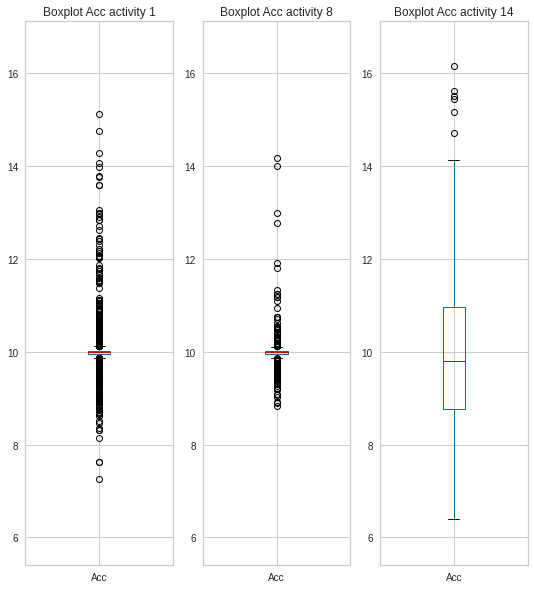

,Label,N Total,N Outliers,Density
1,Stand,11012,762,6.919724
8,Stand to Sit,384,116,30.208333
14,Stand to CS/CS and Talk,254,6,2.362205


In [5]:
def get_density_outliers(data_act):
    k=1.5
    column = data_act.columns[0]

    quart = data_act[column].quantile([0.25,0.75])
    iqr = quart[0.75] - quart[0.25]
    lim = [quart[0.25] - k*iqr, quart[0.75] + k*iqr]

    outliers = data_act.loc[(data_act[column] < lim[0]) | (data_act[column] > lim[1])]
    not_outliers = data_act.loc[(data_act[column] >= lim[0]) & (data_act[column] <= lim[1])]

    return [outliers,not_outliers]

def getDensity(data_act):

    outliers = get_density_outliers(data_act)[0]

    n = data_act.shape[0]

    return [outliers.shape[0] / n * 100, n, outliers.shape[0]]  #densidade, nº de pontos, nº de outliers

def plotBoxplot(data,vec_name):
    column = data.columns[0]

    plt.figure(figsize=(3*len(acts),10))
    act_title=''

    min_v = data.loc[data['Label'].isin(acts),vec_name].min().min()
    max_v = data.loc[data['Label'].isin(acts),vec_name].max().max()
    amp = max_v - min_v

    for i in range(1,len(acts)+1):
        act = acts[i-1]
        plt.subplot(1,len(acts),i)

        data_act = data.loc[data['Label'] == act]

        box = data_act[vec_name].plot.box()
        plt.title('Boxplot ' + vec_name + ' activity ' + str(act))
        if(i!=1):
            act_title += ','
        act_title += str(act)

        box.set_ylim(min_v - 0.1*amp, max_v + 0.1*amp)

    plt.savefig('../Plots/Boxplots/'+'boxplot-' + vec_name + '-acts-' + act_title)
    
    plt.show()

def evaluateDensity(data,title):
    density = [act_labels[acts-1],[],[],[]]
    
    for act in acts:
        data_act = data.loc[data['Label'] == act]
        [dens,n,n_out] = getDensity(data_act)
        density[1].append(n)
        density[2].append(n_out)
        density[3].append(dens)
    
    density[0] = pd.DataFrame(density[0])
    density[0].columns = ['Label']

    for i in range(1,len(density)):
        density[i] = pd.DataFrame(density[i])
        density[i].columns = [modules_labels[i-1]]
    
    density = pd.concat(density,axis=1)
    density.index = acts
    plotBoxplot(data,title)
    
    return density
    
density_acc = evaluateDensity(data_mod[['Acc','Label']], 'Acc')
display(density_acc)

density = density_acc

### 3.2.
<p> As atividades 8 a 11 consistem alternar entre estar em pé e sentado, ou vice-versa, enquanto o indivíduo realiza outras atividades (falar). A densidade de outliers nestes casos é muito alto. Isto pode dever-se a 2 coisas: 

<ul>
<li> O indivíduo pode ter-se movimentado mais rápido nuns momentos do que noutros, gerando uma grande variedade nos valores. 
<li> Como há menos momentos destas atividades (como podemos observar na tabela na columa 'Acc_n'), e dada a situação anterior, os momentos que se tornam outliers tornam-se demasiados em comparação com o número de momentos da atividade em causa.
<ul>

<p> As atividades semelhantes, como <em>Climb Stairs to Walk</em> e <em>Climb Stairs and Talk to Walk and Talk</em> têm densidades semelhantes. Conclui-se, assim, que adicionar a atividade <em>Talk</em> não modifica de forma significativa o número de outliers. Tal acontece também nas outras atividades que apenas é adicionado o <em>Talk</em>, a diferença da densidade de outliers é pequena.

<p> Na atividade <em>Sit</em> (atividade 2) e <em>Sit and Talk</em>, o intervalo de valores é pequeno pois, quando uma pessoa está sentada, não se movimenta pelo que a aceleração no eixo <em>xx'</em> e <em>yy'</em> é perto de 0.

<p> Nas atividades <em>Climb</em> e <em>Climb and Talk</em>, o intervalo de valores é alto pois o indivíduo tem, geralmente, uma aceleração inconstante quando sobe ou desce escadas, gerando os outliers. A densidade é baixa mas quando é gerado um outlier, este tem um valor muito longe da média.

## Z-Score

,Label,N Total,Boxplot,Z-score k=3,Z-score k=3.5,Z-score k=4
1,Stand,11012,762,128,109,98
8,Stand to Sit,384,116,6,6,4
14,Stand to CS/CS and Talk,254,6,2,0,0


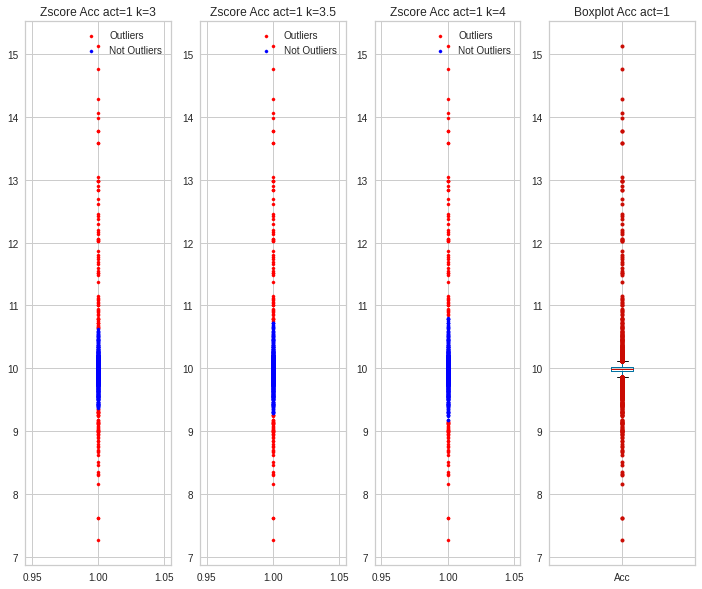

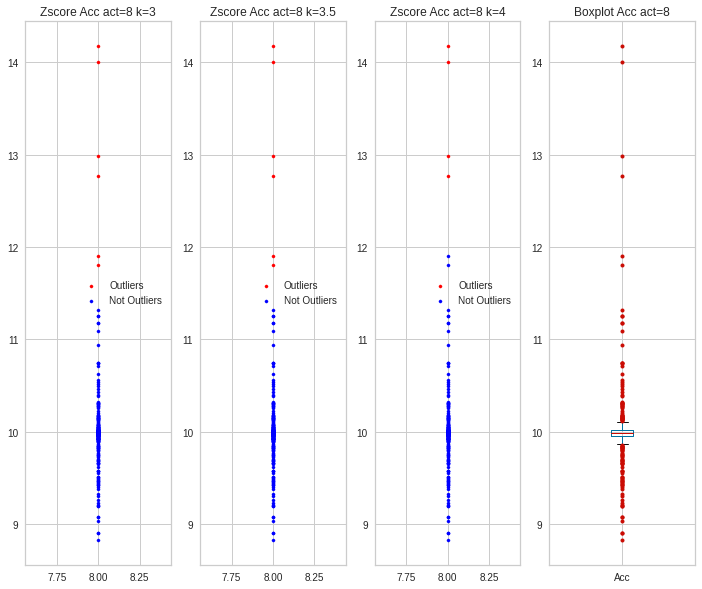

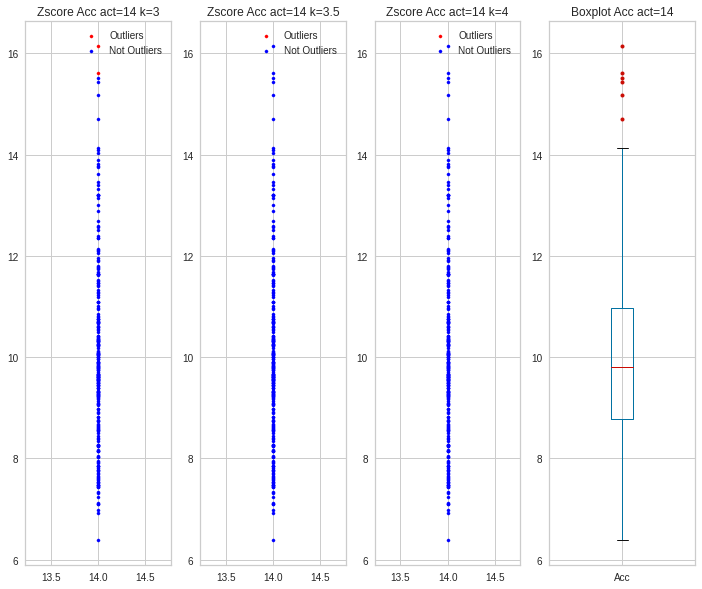

In [6]:
def plotZscore(data,vec_name):
    column = data.columns[0]
    for act in acts:
        data_act = data.loc[data['Label'] == act,column]

        plt.figure(figsize=(3*(len(k_values)+1),10))
        for i in range(1,len(k_values)+1):
            k = k_values[i-1]

            [outliers,not_outliers] = zscore(data_act, data_act.mean(), data_act.std(), k)

            plt.subplot(1,len(k_values)+1,i)
            plt.scatter(np.full((1,outliers.shape[0]),act),outliers,s=10,c='red',label='Outliers')
            plt.scatter(np.full((1,not_outliers.shape[0]),act),not_outliers,s=10,c='blue',label='Not Outliers')
            plt.title('Zscore ' + vec_name + ' act=' + str(act) + ' k=' + str(k))
            plt.legend()

        plt.subplot(1,len(k_values)+1,len(k_values)+1)
        data_act.plot.box(sym='r.')
        plt.title('Boxplot ' + vec_name + ' act=' + str(act))
        plt.savefig('../Plots/Zscores/'+'zscore-act-' + str(act))

def zscore(data, mean, std,k):
    z = (data - mean) / std
    
    out_pos = z.loc[(z < -k) | (z > k)].index
    not_out_pos = z.loc[(z >= -k) & (z <= k)].index

    out = data.loc[out_pos]
    not_out = data.loc[not_out_pos]

    return [out,not_out]

def outliersZscore(density,data,vec_name,n_act=16):
    column = data.columns[0]
    n_outliers = list() 
        
    for act in acts:
        k_out = list()
        for k in k_values:
            data_act = data.loc[data['Label'] == act,column]
            [out,not_out] = zscore(data_act, data_act.mean(), data_act.std(), k)

            k_out.append(out.shape[0])

        df = pd.DataFrame(k_out)
        df.columns = [act]
        df.index = k_values
        n_outliers.append(df)

    n_outliers = pd.concat(n_outliers,axis=1)
    n_outliers = n_outliers.transpose()

    data_zscore = pd.concat([density[['Label','N Total','N Outliers']],n_outliers],axis=1)
    data_zscore = data_zscore.rename(columns = {'N Outliers': 'Boxplot'})

    for k in k_values:
        data_zscore = data_zscore.rename(columns={k: 'Z-score k=' + str(k)})

    plotZscore(data,vec_name)
    
    dfi.export(data_zscore,'../Plots/Tables/table-zscore-' + vec_name.lower() + '.png')
    
    return data_zscore

acc_zscore = outliersZscore(density_acc,data_mod[['Acc','Label']],'Acc')

display(acc_zscore)

### 3.5.

<p> A análise de outliers através do Boxplot é feito através da densidade. Logo, quando os dados estão concentrados, este método vais ser muito sensível a outliers pois o limite para os definir vai ser curto. No caso do Z-score, os outliers são os valores que estão mais afastados da média <em>x</em> desvios padrões. Olhando para uma distribuição normal, estão mais no exterior da mesma, sendo um algoritmo menos sensível a outliers.

<p> Conseguimos perceber que o estudo da densidade considera certos pontos como outliers quando estes estão num zona concentrada. No caso do Z-score, já conseguimos detetar os outliers quando estes estão mais dispersos e escassos.

In [7]:
def assign_clusters(data, centroids):
    for index, row in data.iterrows():
        for i in range(len(centroids)):
            d_actual = np.sqrt((row['X'] - centroids[int(row['Clusters'])][0])**2 + (row['Y'] - centroids[int(row['Clusters'])][1])**2 + (row['Z'] - centroids[int(row['Clusters'])][2])**2)
            d_compare = np.sqrt((row['X'] - centroids[i][0])**2 + (row['Y'] - centroids[i][1])**2 + (row['Z'] - centroids[i][2])**2)
            if (d_actual > d_compare):
                data.loc[index, 'Clusters'] = i
                data.loc[index, 'Distance'] = d_compare
    return data

def update_centroids(data, centroids):
    for i in range(len(centroids)):
        centroids[i][0] = data['X'].loc[data['Clusters'] == i].mean()
        centroids[i][1] = data['Y'].loc[data['Clusters'] == i].mean()
        centroids[i][2] = data['Z'].loc[data['Clusters'] == i].mean()
    
    return centroids
        
def k_means(n_clusters, data):
    centroids = [[] for _ in range(n_clusters)]
    
    for i in range(n_clusters):
        centroids[i] = data.sample().to_numpy()[0]
        
    data['Clusters'] = 0
    data['Distance'] = 0
    prev_clusters = data['Clusters'].copy()
    
    while(True):
        data = assign_clusters(data, centroids)
        
        if (data['Clusters'].equals(prev_clusters)):
            break
        
        centroids = update_centroids(data, centroids)
        prev_clusters = data['Clusters'].copy()
        
    return [data, centroids]
    

def clusters_kmeans(n_clusters, data, act):
    data = data.loc[data['Act_Label'] == act]
    
    acc_xyz = data[['Acc_X', 'Acc_Y', 'Acc_Z']]
    acc_xyz = acc_xyz.rename(columns={"Acc_X":"X", "Acc_Y":"Y", "Acc_Z":"Z"})
    gyr_xyz = data[['Gyr_X', 'Gyr_Y', 'Gyr_Z']]
    gyr_xyz = gyr_xyz.rename(columns={'Gyr_X':'X', 'Gyr_Y':'Y', 'Gyr_Z':'Z'})
    mag_xyz = data[['Mag_X', 'Mag_Y', 'Mag_Z']]
    mag_xyz = mag_xyz.rename(columns={'Mag_X':'X', 'Mag_Y':'Y', 'Mag_Z':'Z'})
    
    [acc_xyz, centroids] = k_means(n_clusters, acc_xyz)
#     [gyr_xyz, centroids] = k_means(n_clusters, gyr_xyz)
#     [mag_xyz, centroids] = k_means(n_clusters, mag_xyz)
    
    # %matplotlib notebook
    # threedee = plt.figure().gca(projection='3d')
    # for i in range(n_clusters):
    #    cluster_label = 'Cluster '+str(i)
    #    plot_data = acc_xyz.loc[acc_xyz['Clusters'] == i]
    #    threedee.scatter(plot_data['X'], plot_data['Y'], plot_data['Z'], marker='o', label=cluster_label)
    # title = 'Accelerometer kmeans'
    # plt.title(title)
    # threedee.legend()
    
#     fig2 = plt.figure()
#     ax = plt.axes(projection='3d')
#     for i in range(n_clusters):
#         plot_data = gyr_xyz.loc[gyr_xyz['Clusters'] == i]
#         ax.scatter3D(plot_data['X'], plot_data['Y'], plot_data['Z'])
    
#     fig3 = plt.figure()
#     ax = plt.axes(projection='3d')
#     for i in range(n_clusters):
#         plot_data = mag_xyz.loc[mag_xyz['Clusters'] == i]
#         ax.scatter3D(plot_data['X'], plot_data['Y'], plot_data['Z'])
    kmeanModel = KMeans(n_clusters=n_clusters)
    kmeanModel.fit(acc_xyz)

    return [acc_xyz,kmeanModel.inertia_]
    
# acc_clusters = clusters_kmeans(6, data, 1)

In [8]:
def createDf(clusters=[2],n_act=16):
    dfs = list()
    elbow = list()
    for clust in clusters:
        vec = list()
        vec_elbow = list()
        for act in range(1,n_act+1):
            vec.append(None)
            vec_elbow.append(None)
        elbow.append(vec_elbow)
        df = pd.DataFrame(vec)
        df.columns = [clust]
        dfs.append(df)
    
    dfs = pd.concat(dfs,axis=1)
    dfs.index = dfs.index+1

    return [dfs,elbow]

# clusters_values = [2,3,4,5,6,7,8]
# [kmeans_vec,elbow] = createDf(clusters_values)

In [9]:
def outliersKmeans(data,kmeans_vec,elbow,n_clust=7,n_act=16):
    for act in kmeans_vec.index:
        print('act',act)
        for clust in [6]:
            print('clust',clust)
            if(kmeans_vec[clust][act] == None):
                [clusters,dist] = clusters_kmeans(clust, data, act)
                elbow[clust-clusters_values[0]][act-1] = dist
                count = clusters['Clusters'].value_counts()
                minCluster = clusters.loc[clusters['Clusters'] == count.index[-1]]
                kmeans_vec[clust][act] = minCluster.shape[0]

    elbow = pd.DataFrame(elbow)

    return [kmeans_vec,elbow]

# display(acc_clusters)
# display(acc_clusters)
# print(kmeans_vec.index)
# [kmeans_vec,elbow] = outliersKmeans(data,kmeans_vec,elbow)
# display(kmeans_vec)
# display(elbow)


In [10]:
# elbow = np.array(elbow)
# plt.plot(clusters_values,elbow[:,0])

# display(kmeans_vec)
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(4,12))

# act = 8
# x = data.loc[data['Act_Label'] == act,['Acc_X','Acc_Y']].to_numpy()
# print(x)
# visualizer.fit(x)        # Fit the data to the visualizer
# visualizer.show()


### 3.7.

<p> O k-means é um algoritmo que, quando utilizado para detetar outliers, separa-os devido às suas coordenadas. Ou seja, um ponto tem de estar afastado dos restantes pontos. Ao contrário deste algoritmo, o z-score avalia os outliers pela sua distância ao centro. Pode acontecer um ponto ter uma coordenada muito mais alta que as outras e é considerado outlier pelo z-score mas não pelo k-means pois pode estar próximo de outros pontos e formar um cluster.</p>

## Exercício 3.8

In [11]:
def outlier_injection(data, x, k=3):
    max_iterations = 10
    iterations = 0
    
    data = data.copy()
    
    mean = data.mean()
    std = data.std()
    
    out, non_out = zscore(data, mean, std, k)
    out_dens = out.count()/data.count() * 100
        
    print('Initial density: {:.3f}\tOutliers count: {:d}'.format(out_dens, out.count()))
    
    while (out_dens < 0.99*x and iterations < max_iterations): 
        z = abs(max(out) - (mean + k*std))
        
        d = x - out_dens
        n_points = int(np.ceil(d*data.count() / 100))
        inj_points = non_out.sample(n_points)
        
        for index, value in inj_points.items():
            s = np.random.randint(2)
            if s == 0:
                s = -1
            q = np.random.uniform(0, z)
            data[index] = mean + s*k*(std + q)
        
        out, non_out = zscore(data, mean, std, k)
        out_dens = out.count()/data.count() * 100
        iterations += 1
        print('Iteration: {:d}\tOutlier Density: {:.3f}'.format(iterations, out_dens))
    
    print('Final density: {:.3f}\tOutliers count: {:d}'.format(out_dens, out.count()))
    return [data, out, non_out]

# Exercício 3.9

In [12]:
def linear_model(window, p):
    y = np.matrix([[window[i]] for i in range(p, len(window)) ])
    x = []
    for i in range(p, len(window)):
        aux = [window[i - j] for j in range(1, p+1)]
        aux.insert(0, 1)
        x.append(aux)
    x = np.matrix(x)
    
    return np.squeeze(np.asarray(np.dot(np.linalg.pinv(x), y)))

def linear_model_center(window, p):
    p2 = int(np.floor(p/2))
    
    y = np.matrix([[window[i]] for i in range(p2, len(window)-p2) ])
    x = []
    for i in range(p2, len(window)-p2):
        aux = [window[i - j] for j in range(1, p2+1)]
        aux.reverse()
        aux1 = [window[i + j] for j in range(1, p2+1)]
        aux.extend(aux1)
        aux.insert(0, 1)
        x.append(aux)
    x = np.matrix(x)
    
    return np.squeeze(np.asarray(np.dot(np.linalg.pinv(x), y)))

# Exercício 3.10

In [13]:
window_size = 30
num_p = 15

def LOO(window, p_test, model = 'normal'):
    errors = []
    
    for p in p_test:
        error = 0
        if model == 'normal':
            for i in range(p, len(window)):
                aux = window[:i]
                aux1 = window[i+1:]
                aux.extend(aux1)
                
                betas = linear_model(aux, p)
                
                predicted_value = 0
                predicted_value += betas[0]
                for j in range(1, len(betas)):
                    predicted_value += betas[j]*window[i-j]
                    
                error += np.power(window[i] - predicted_value, 2)
            errors.append(error)
        else:
            for i in range(int(np.floor(p/2)), len(window)-int(np.floor(p/2))):
                aux = window[:i]
                aux1 = window[i+1:]
                aux.extend(aux1)
                
                betas = linear_model_center(aux, p)
                
                predicted_value = 0
                predicted_value += betas[0]
                for j in range(1, round(len(betas)/2)):
                    predicted_value += betas[j]*window[i-j]
                for j in range(1, round(len(betas)/2)):
                    predicted_value += betas[int(np.floor(len(betas)/2))+j]*window[i+j]
            
                error += np.power(window[i] - predicted_value, 2)
            errors.append(error)
    
#     plt.figure(figsize=(10,10))
#     plt.bar(p_test, errors)
#     plt.plot(p_test, errors, color='red')
    
#     print('Best p value: {:d}'.format(p_test[errors.index(min(errors))]))
    
    return(p_test[errors.index(min(errors))])

In [14]:
def ex3_10(data):
    errors = []
    outliers_test = []
    pred_outliers = []
    
    [inj_data, outliers, non_outliers] = outlier_injection(data, 10)
    
    frame = {
        'Real Values': inj_data,
        'Predicted Values': inj_data,
        'Was Predicted': [False for _ in range(len(inj_data))],
        'Category': ['Non Outlier' for _ in range(len(inj_data))]
    }
    
    df = pd.DataFrame(frame)
    df.loc[df.index.isin(outliers.index), 'Category'] = 'Outlier'
    
    pred_data_indexes = inj_data.index.values.tolist() 
    pred_data = inj_data.tolist()
    inj_data_indexes = inj_data.index.values.tolist()
    inj_data = inj_data.tolist()
    
    for index, value in df.loc[df['Category'] == 'Outlier']['Real Values'].items():
        if index <= num_p:
            continue
        
        if index < window_size:
            window = df[:index]
        else:
            window = df[index-window_size:index]
        
#         if window.any():
#             print(encontrei)
        
#         p = LOO(window, [i for i in range(1, num_p+1)])
#         betas = linear_model(window, p)
        
#         pred_data[i] = 0
#         for j in range(len(betas)):
#             if j==0:
#                 pred_data[i] += betas[j]
#             else:
#                 pred_data[i] += betas[j]*inj_data[i-j]
        
#         errors.append(inj_data[i]-pred_data[i])
#         outliers_test.append(inj_data[i])
#         pred_outliers.append(pred_data[i])
    
#     errors = np.array(errors)
#     plt.figure(figsize=(10,10))
#     plt.hist(errors, bins=int(len(np.unique(errors))/2))
    
#     out_plot = outliers.sample(5)
#     for out_index, value in out_plot.items():
#         i = inj_data_indexes.index(out_index)
#         real_values = inj_data[i-window_size:i+1]
#         predicted_values = pred_data[i-window_size:i+1]
        
#         plt.figure(figsize=(10,10))
#         plt.scatter(pred_data_indexes[i-window_size:i+1], predicted_values, color='red', label='Predicted Values')
#         plt.scatter(inj_data_indexes[i-window_size:i+1], real_values, color='blue', label='Original Values')
#         plt.legend()
#     print(len(outliers_test))
#     outliers = outliers.tolist()
#     plt.figure(figsize=(10, 10))
#     plt.scatter([i for i in range(len(outliers_test))], outliers_test, color='blue', label='Original Values')
#     plt.scatter([i for i in range(len(pred_outliers))], pred_outliers, color='red', label='Predicted Values')
#     plt.legend()   
    
ex3_10(data_mod.loc[data_mod['Label'] == 1]['Acc'])

Initial density: 1.162	Outliers count: 128
Iteration: 1	Outlier Density: 10.007
Final density: 10.007	Outliers count: 1102


# Exercício 3.11

Initial density: 1.162	Outliers count: 128
Iteration: 1	Outlier Density: 10.007
Final density: 10.007	Outliers count: 1102


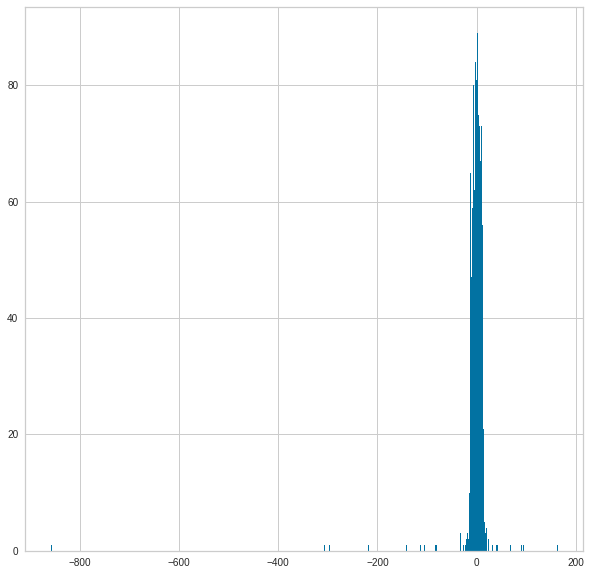

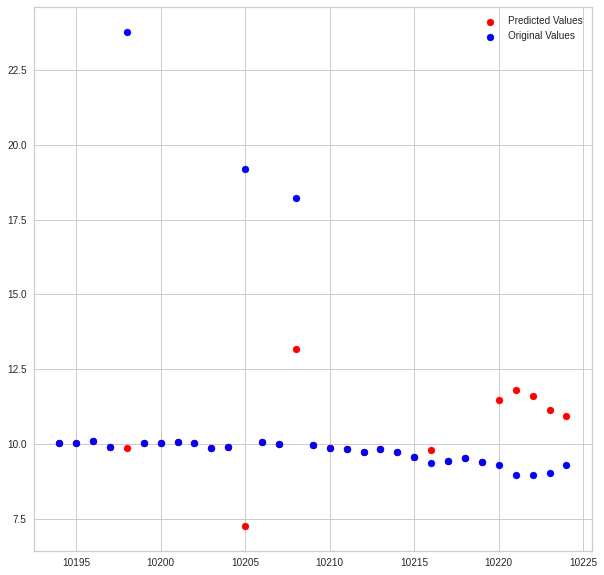

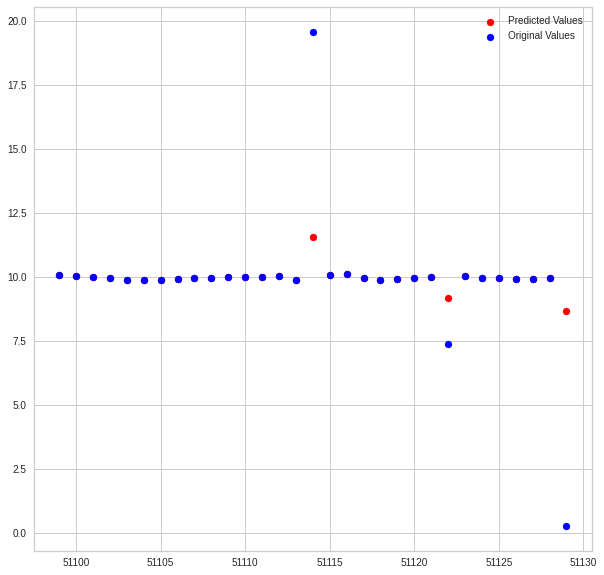

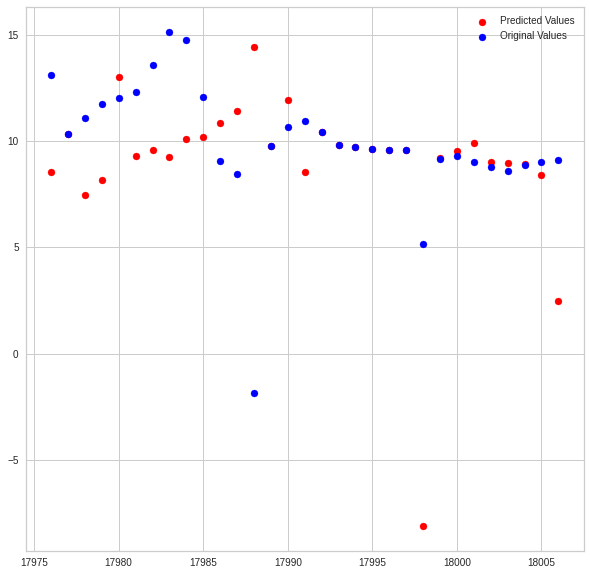

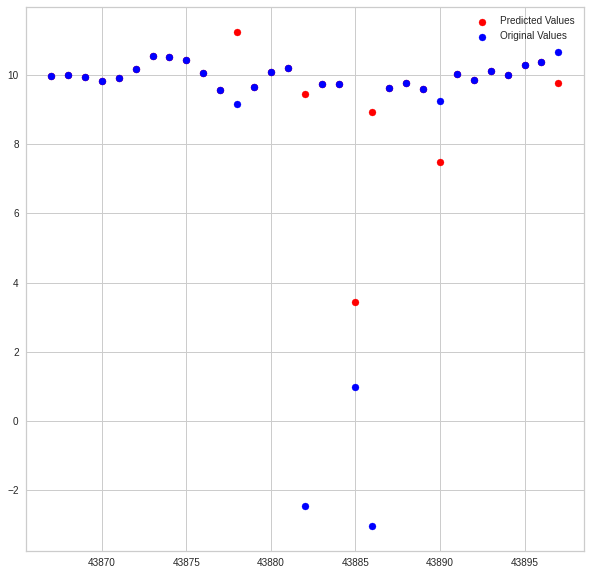

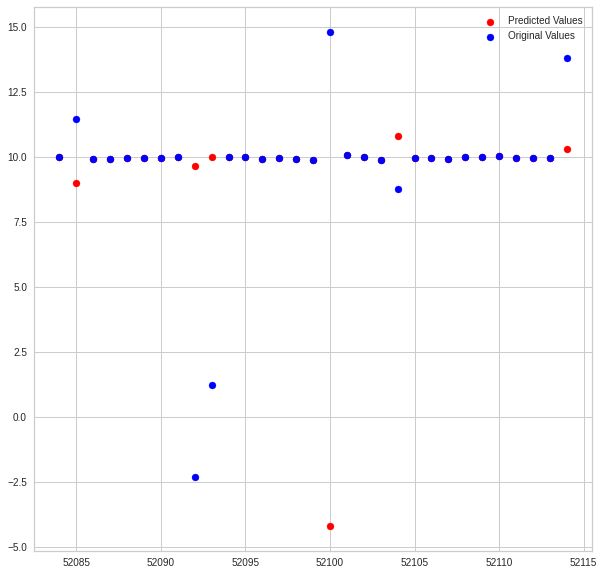

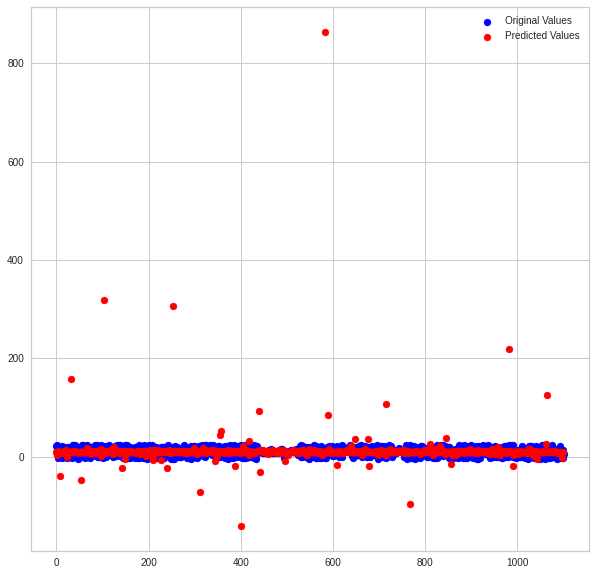

In [15]:
def ex3_11(data):
    p = LOO(data.tolist()[:window_size+1], [i for i in range(3, num_p+1, 2)], 'centered')
    errors = []
    pred_outliers = []
    
    [inj_data, outliers, non_outliers] = outlier_injection(data, 10)
    
    pred_data_indexes = inj_data.index.values.tolist() 
    pred_data = inj_data.tolist()
    inj_data_indexes = inj_data.index.values.tolist()
    inj_data = inj_data.tolist()
    
    for out_index, value in outliers.items():
        if out_index <= p:
            continue
            
        i = inj_data_indexes.index(out_index)    
        if out_index < window_size:
            window = inj_data[:i]
            aux = inj_data[i+1:2*i]
            window.extend(aux)
        else:
            window = inj_data[i-round(window_size/2):i]
            aux = inj_data[i+1:i+round(window_size/2)]
            window.extend(aux)
            
        betas = linear_model_center(window, p)
        
        pred_data[i] = 0
        for j in range(len(betas)):
            if j==0:
                pred_data[i] += betas[j]
            else:
                pred_data[i] += betas[j]*inj_data[i-j]
        
        errors.append(inj_data[i]-pred_data[i])
        pred_outliers.append(pred_data[i])
    
    errors = np.array(errors)
    plt.figure(figsize=(10,10))
    plt.hist(errors, bins=int(len(np.unique(errors))/2))
    
    out_plot = outliers.sample(5)
    for out_index, value in out_plot.items():
        i = inj_data_indexes.index(out_index)
        real_values = inj_data[i-window_size:i+1]
        predicted_values = pred_data[i-window_size:i+1]
        
        plt.figure(figsize=(10,10))
        plt.scatter(pred_data_indexes[i-window_size:i+1], predicted_values, color='red', label='Predicted Values')
        plt.scatter(inj_data_indexes[i-window_size:i+1], real_values, color='blue', label='Original Values')
        plt.legend()
    
    outliers = outliers.tolist()
    plt.figure(figsize=(10, 10))
    plt.scatter([i for i in range(len(outliers))], outliers, color='blue', label='Original Values')
    plt.scatter([i for i in range(len(pred_outliers))], pred_outliers, color='red', label='Predicted Values')
    plt.legend()
        
ex3_11(data_mod.loc[data_mod['Label'] == 1]['Acc'])

# Exercício 4

In [25]:
def ex4_1(data):
    df = data.copy()
    acts = df['Label'].sort_values().unique()
    
    for i in range(len(acts)):
        df_acc = df.loc[df['Label'] == acts[i]]['Acc']
        df_gyr = df.loc[df['Label'] == acts[i]]['Gyr']
        df_mag = df.loc[df['Label'] == acts[i]]['Mag']
    
        ks_stats_acc, p_value_acc = stats.kstest(df_acc, 'norm', (df_acc.mean(), df_acc.std()))
        ks_stats_gyr, p_value_gyr = stats.kstest(df_gyr, 'norm', (df_gyr.mean(), df_gyr.std()))
        ks_stats_mag, p_value_mag = stats.kstest(df_mag, 'norm', (df_mag.mean(), df_mag.std()))
    
        print('\nActivity: {:s} ({:d})'.format(act_labels[i], int(acts[i])))
        print('Accelerator Module\nKS statistic: ', ks_stats_acc,'\tP value: ', p_value_acc)
        print('Gyroscope Module\nKS statistic: ', ks_stats_gyr,'\tP value: ', p_value_gyr)
        print('Magnetometer Module\nKS statistic: ', ks_stats_mag,'\tP value: ', p_value_mag)
        
ex4_1(data_mod)


Activity: Stand (1)
Accelerator Module
KS statistic:  0.2795907823869306 	P value:  0.0
Gyroscope Module
KS statistic:  0.3590710211246676 	P value:  0.0
Magnetometer Module
KS statistic:  0.16367529222610222 	P value:  2.9574470412152124e-258

Activity: Sit (2)
Accelerator Module
KS statistic:  0.12885751383761346 	P value:  7.6768381606937935e-84
Gyroscope Module
KS statistic:  0.2755456731761306 	P value:  0.0
Magnetometer Module
KS statistic:  0.10718044642761915 	P value:  4.476684570053333e-58

Activity: Sit and Talk (3)
Accelerator Module
KS statistic:  0.14310682601639754 	P value:  2.1434834794456207e-103
Gyroscope Module
KS statistic:  0.14576745660008594 	P value:  2.811399310901403e-107
Magnetometer Module
KS statistic:  0.024888993937678294 	P value:  0.0015642353570509229

Activity: Walk (4)
Accelerator Module
KS statistic:  0.08131124352023544 	P value:  1.618560092191503e-50
Gyroscope Module
KS statistic:  0.03287518762363071 	P value:  1.3091214759550656e-08
Magnetome

# Exercício 4.2

In [1]:
data_init = read_file()
display(data_init)


######################################### STATISTICAL

def mean(window,vec_name):
    return [window[vec_name + ' X'].mean(), window[vec_name + ' Y'].mean(), window[vec_name + ' Z'].mean()]

def median(window,vec_name):
    return [window[vec_name + ' X'].median(), window[vec_name + ' Y'].median(), window[vec_name + ' Z'].median()]

def std(window,vec_name):
    return [window[vec_name + ' X'].std(), window[vec_name + ' Y'].std(), window[vec_name + ' Z'].std()]

def variance(window,vec_name):
    return [window[vec_name + ' X'].var(), window[vec_name + ' Y'].var(), window[vec_name + ' Z'].var()]

def rms(window,vec_name):
    x = ((window[vec_name + ' X'] ** 2).sum() / window.shape[0])**0.5
    y = ((window[vec_name + ' Y'] ** 2).sum() / window.shape[0])**0.5
    z = ((window[vec_name + ' Z'] ** 2).sum() / window.shape[0])**0.5
    return [x, y, z]

def ad(window,vec_name):
    x = window[vec_name + ' X'].diff() * f
    y = window[vec_name + ' Y'].diff() * f
    z = window[vec_name + ' Z'].diff() * f
    
    return [x.sum() / x.shape[0], y.sum() / x.shape[0], z.sum() / x.shape[0]]

def skewness(window,vec_name):
    return [window[vec_name + ' X'].skew(), window[vec_name + ' Y'].skew(), window[vec_name + ' Z'].skew()]

def kurtosis(window,vec_name):
    return [window[vec_name + ' X'].kurtosis(), window[vec_name + ' Y'].kurtosis(), window[vec_name + ' Z'].kurtosis()]

def iqr(window,vec_name):
    x = window[vec_name + ' X'].quantile(0.75) - window[vec_name + ' X'].quantile(0.25)
    y = window[vec_name + ' Y'].quantile(0.75) - window[vec_name + ' X'].quantile(0.25)
    z = window[vec_name + ' Z'].quantile(0.75) - window[vec_name + ' X'].quantile(0.25)
    return [x, y, z]

def zcr_mcr(window,vec_name):
    x_zcr = 0
    y_zcr = 0
    z_zcr = 0

    x_mcr = 0
    y_mcr = 0
    z_mcr = 0
    
    [x_mean,y_mean,z_mean] = mean(window,vec_name)

    for i in range(len(window.index)-1):
        index1 = window.index[i]
        index2 = window.index[i+1]

        if(window[vec_name + ' X'][index1] * window[vec_name + ' X'][index2] < 0):
            x_zcr += 1
        if(window[vec_name + ' Y'][index1] * window[vec_name + ' Y'][index2] < 0):
            y_zcr += 1
        if(window[vec_name + ' Z'][index1] * window[vec_name + ' Z'][index2] < 0):
            z_zcr += 1

        if((window[vec_name + ' X'][index1] - x_mean) * ((window[vec_name + ' X'][index2] - x_mean)) < 0):
            x_mcr += 1
        if((window[vec_name + ' Y'][index1] - y_mean) * ((window[vec_name + ' Y'][index2] - y_mean)) < 0):
            y_mcr += 1
        if((window[vec_name + ' Z'][index1] - z_mean) * ((window[vec_name + ' Z'][index2] - z_mean))):
            z_mcr += 1

    return [x_zcr, y_zcr, z_zcr, x_mcr, y_mcr, z_mcr]

def par_corr(window):
    corr_df = window.corr()
    cols = corr_df.columns
    
    corr = []
    for i in range(cols.shape[0]):
        for j in range(i+1,cols.shape[0]):
            corr.append(corr_df[cols[i]][cols[j]])
            
    return corr

def spectral_entropy(x, sf=f, method='fft', nperseg=None, normalize=False):
    # https://raphaelvallat.com/entropy/build/html/generated/entropy.spectral_entropy.html
    x = np.array(x)
    if method == 'fft':
        _, psd = periodogram(x, sf)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg)
    psd_norm = np.divide(psd, psd.sum())
    se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
    if normalize:
        se /= np.log2(psd_norm.size)
    return se

def spec_ent(window,vec_name):
    x = spectral_entropy(window[vec_name + ' X'])
    y = spectral_entropy(window[vec_name + ' Y'])
    z = spectral_entropy(window[vec_name + ' Z'])
    return [x, y, z]

######################################### TEMPORAL

def mov_int(window,vec_name):
    mi = np.sqrt(window[vec_name + ' X']**2 + window[vec_name + ' Y']**2 + window[vec_name + ' Z']**2)
    
    ai = mi.sum() / mi.shape[0]
    vi= ((mi - ai)**2).sum() / mi.shape[0]

    return [ai,vi]

def nor_sig(window,vec_name):
    window['sma'] = window[vec_name + ' X'].abs() + window[vec_name + ' Y'].abs() + window[vec_name + ' Z'].abs()
    
    sma = window['sma'].sum() / window.shape[0]
      
    return [sma]

def eva(window,vec_name):
    x_cov = window[[vec_name + ' X',vec_name + ' Y',vec_name + ' Z']].cov()
    eig_values = sorted(np.linalg.eig(x_cov)[0])
    
    return [eig_values[-1],eig_values[-2]]
    
#     sma = window['sma'].sum() / window.shape[0]
      
    return [0]

def cagh(window,vec_name):
    heading = np.sqrt(window[vec_name + ' Y']**2 + window[vec_name + ' Z']**2)
    gravity = window[vec_name + ' X']
    
    corr = par_corr(pd.DataFrame([heading,gravity]).transpose()) 
    return corr

def velocity(window,vec_name):
    v_x = []
    v_y = []
    v_z = []
    x = window[vec_name + ' X']
    y = window[vec_name + ' Y']
    z = window[vec_name + ' Z']
    for i in range(len(window.index)-1):
        index1 = window.index[i]
        index2 = window.index[i+1]
        
        v_x.append((x[index1] + x[index2]) / (2 * f))
        v_y.append((y[index1] + y[index2]) / (2 * f))
        v_z.append((z[index1] + z[index2]) / (2 * f))
        
    return [v_x,v_y,v_z]

def avh_avg(window,vec_name):
    [v_x, v_y, v_z] = velocity(window,vec_name)
    
    v_h = np.sqrt(np.power(v_y,2) + np.power(v_z,2))
    
    return [np.mean(v_h),np.mean(v_x)]

######################################### SPECTRAL
    
def dom_freq(window,vec_name):
    freqs, x = signal.welch(window[vec_name + ' X'], f)
    max_x = freqs[x.argmax()]
    
    freqs, y = signal.welch(window[vec_name + ' Y'], f)
    max_y = freqs[y.argmax()]
    
    freqs, z = signal.welch(window[vec_name + ' Z'], f)
    max_z = freqs[z.argmax()]
    
    return [max_x,max_y,max_z]

def energy(window,vec_name):
    freqs, x = signal.welch(window[vec_name + ' X'], f)
    mean_x = np.mean(x)
    
    freqs, y = signal.welch(window[vec_name + ' Y'], f)
    mean_y = np.mean(y)
    
    freqs, z = signal.welch(window[vec_name + ' Z'], f)
    mean_z = np.mean(y)
    
    return [mean_x,mean_y,mean_z,(mean_x + mean_y + mean_z) / 3]
    
#########################################

def normalize_features(features):
    for c in features.columns[1:]:
        features[c] = (features[c] - features[c].mean()) / features[c].std()

    return features

#########################################

def plot_statistics(features,n):
    for f in range(1,n*3*12,3):
        col = features.columns[f][:4] + features.columns[f][6:]
        fig = px.scatter_3d(features, x=features.columns[f], y=features.columns[f+1], z=features.columns[f+2], color=features['Label Name'], title=col,
                           color_discrete_sequence=px.colors.qualitative.Light24)
        fig.update_traces(marker=dict(size=4))
        fig.show()
        
def plot_temporal(features,vecs):
    for v in vecs:
        if(v == 'Acc'):
            cols = [v + ' AI',v + ' SMA']
            fig = px.scatter(features, x=cols[0], y=cols[1], color=features['Label Name'], title=v + ' AI vs SMA',
                               color_discrete_sequence=px.colors.qualitative.Light24)
            fig.update_traces(marker=dict(size=4))
            fig.show()

            cols = [v + ' EVA Heading',v + ' EVA Gravity']
            fig = px.scatter(features, x=cols[0], y=cols[1], color=features['Label Name'], title=v + ' EVA Heading vs Gravity',
                               color_discrete_sequence=px.colors.qualitative.Light24)
            fig.update_traces(marker=dict(size=4))
            fig.show()

            cols = [v + ' AVH',v + ' AVG']
            fig = px.scatter(features, x=cols[0], y=cols[1], color=features['Label Name'], title=v + ' AVH vs AVG',
                               color_discrete_sequence=px.colors.qualitative.Light24)
            fig.update_traces(marker=dict(size=4))
            fig.show()
        
def plot_corr(features,vecs):
    x = np.full((features.shape[0]),1)
    
    for v in vecs:
        cols = [v + ' X Y Corr',v + ' X Z Corr',v + ' Y Z Corr']
        for col in cols:
            fig = px.scatter(features, x=col, y=x, color=features['Label Name'], title=col,
                               color_discrete_sequence=px.colors.qualitative.Light24)
            fig.update_traces(marker=dict(size=4))
            fig.show()
        
def plot_spectral(features,vecs):
    for v in vecs:
        cols = [v + ' X DF', v + ' Y DF', v + ' Z DF']
        fig = px.scatter_3d(features, x=cols[0], y=cols[1], z=cols[2], color=features['Label Name'], title=v + ' DF',
                           color_discrete_sequence=px.colors.qualitative.Light24)
        fig.update_traces(marker=dict(size=4))
        fig.show()     
        
        for axis in [' X',' Y',' Z']:
            cols = [v + axis + ' Std',v + axis + ' Energy']
            print(cols)
            fig = px.scatter(features, x=cols[0], y=cols[1], color=features['Label Name'], title=v + axis + ' Sigma vs Energy',
                               color_discrete_sequence=px.colors.qualitative.Light24)
            fig.update_traces(marker=dict(size=4))
            fig.show()
        
    if('Acc' in vecs and 'Gyr' in vecs):
        cols = ['Acc AAE', 'Gyr ARE']
        fig = px.scatter(features, x=cols[0], y=cols[1], color=features['Label Name'], title='AAE vs ARE',
                           color_discrete_sequence=px.colors.qualitative.Light24)
        fig.update_traces(marker=dict(size=4))
        fig.show()   
        
#########################################
        
def calculate_features(data, t, n_acts=16):
    
    f_window = int(f*t)
    
    
    vecs = ['Acc',
            'Gyr'
           ]
    vec_values=[]
    for vec_name in vecs:
        print(vec_name)
        act_values = []
        for act in range(1,n_acts+1):
            print('act',act)
            data_act = data.loc[data['Label'] == act]

            for i in range(0,data_act.shape[0] - data_act.shape[0] % f_window,f_window):
                values = []

                window = data_act[[vec_name + ' X',vec_name + ' Y',vec_name + ' Z']].iloc[i:i+f_window]
                n=1
                if(vec_name == vecs[0]):
                    values += [act]
                #Statistical
                values += mean(window, vec_name)
                values += median(window, vec_name)
                values += std(window, vec_name)
                values += variance(window, vec_name)
                values += rms(window, vec_name)
                values += ad(window, vec_name)
                values += skewness(window, vec_name)
                values += kurtosis(window, vec_name)
                values += iqr(window, vec_name)
                values += zcr_mcr(window, vec_name)
                values += par_corr(window)
                values += spec_ent(window, vec_name)
                #Temporal
                if(vec_name == 'Acc'):
                    values += mov_int(window,vec_name)
                    values += nor_sig(window,vec_name)
                    values += eva(window,vec_name)
                    values += cagh(window,vec_name)
                    values += avh_avg(window,vec_name)
                elif(vec_name == 'Gyr'):
                    values += cagh(window,vec_name)
                #Spectral
                values += dom_freq(window,vec_name)
                values += energy(window,vec_name)
                
                act_values.append(values)
            

        df = pd.DataFrame(act_values)
        statistical = [vec_name + ' X Mean',vec_name + ' Y Mean',vec_name + ' Z Mean',
                   vec_name + ' X Medians',vec_name + ' Y Medians',vec_name + ' Z Medians',
                   vec_name + ' X Std',vec_name + ' Y Std',vec_name + ' Z Std',
                   vec_name + ' X Variance',vec_name + ' Y Variance',vec_name + ' Z Variance',
                   vec_name + ' X RMS',vec_name + ' Y RMS',vec_name + ' Z RMS',
                   vec_name + ' X AD',vec_name + ' Y AD',vec_name + ' Z AD',
                   vec_name + ' X Skewness',vec_name + ' Y Skewness',vec_name + ' Z Skewness',
                   vec_name + ' X Kurtosis',vec_name + ' Y Kurtosis',vec_name + ' Z Kurtosis',
                   vec_name + ' X IQR',vec_name + ' Y IQR',vec_name + ' Z IQR',
                   vec_name + ' X ZCR',vec_name + ' Y ZCR',vec_name + ' Z ZCR',
                   vec_name + ' X MCR',vec_name + ' Y MCR',vec_name + ' Z MCR',
                   vec_name + ' X Y Corr', vec_name + ' X Z Corr', vec_name + ' Y Z Corr',
                   vec_name + ' X Spec Ent',vec_name + ' Y Spec Ent',vec_name + ' Z Spec Ent',
        ]
        
        if(vec_name == 'Acc'):
            temporal = [vec_name + ' AI', vec_name + ' VI',
                    vec_name + ' SMA',
                    vec_name + ' EVA Gravity', vec_name + ' EVA Heading',
                    vec_name + ' CAGH',
                    vec_name + ' AVH', vec_name + ' AVG'
                   ]
        elif(vec_name == 'Gyr'):
            temporal = [vec_name + ' CAGH']
            
        spectral = [vec_name + ' X DF', vec_name + ' Y DF', vec_name + ' Z DF',
                    vec_name + ' X Energy', vec_name + ' Y Energy', vec_name + ' Z Energy']
        
        if(vec_name == 'Acc'):
            spectral += [vec_name + ' AAE']
        elif(vec_name == 'Gyr'):
            spectral += [vec_name + ' ARE']
        
        columns = []
        if(vec_name == vecs[0]):
            columns = ['Label']
        columns += statistical + temporal + spectral
        
        df.columns = columns
        vec_values.append(df)
        
    labels = pd.DataFrame(act_labels[vec_values[0]['Label']-1])
    labels.columns = ['Label Name']
    features = pd.concat([labels]+vec_values,axis=1)
    
    print('Number of features:', features.columns.shape[0])
    
    features = normalize_features(features)
    display(features)
    
#     plot_statistics(features[['Label']+statistical],len(vecs))
#     plot_temporal(features,vecs)
    
#     plot_corr(features,vecs)
    plot_spectral(features,vecs)
    return features

data_init = read_file(15)
features = calculate_features(data_init,2)

NameError: name 'read_file' is not defined